In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable
from numpy import linalg

## Gradient Descent implementation

Обобщённая реализация градиентного спуска

In [2]:
def grad_descent(
    grad: Callable[[np.ndarray], np.ndarray], # gradient of f(x)
    x0: np.ndarray,                           # starting point of the descent
    step_fun: Callable[[list], float],        # function which decides the length of the next step
    max_epoch: int = 100,                     # algorithm stops when number of iterations reach max_epoch
    eps: float = 0                            # algorithm stops when ||grad(x)|| < eps
) -> np.ndarray:                              # returns the path gradient descent takes from x0
  points = [x0]

  for i in range(1, max_epoch):
    x_prev = points[-1]
    lr: float = step_fun(points)
    x_new: np.ndarray = x_prev - lr * grad(x_prev)
    points.append(x_new)
    if linalg.norm(grad(x_new), len(x_new)) < eps:
      break

  return np.array(points)

## Constant Learning rate

реализация градиентного спуска с постоянным шагом

In [3]:
def gd_const_lr(
        grad: Callable,
        x0: np.ndarray,
        lr: float, # constant learning rate
        max_epoch: int = 10,
        eps: float = 0
) -> np.ndarray:
  return grad_descent(grad, x0, lambda _: lr, max_epoch, eps)

Исследуем сходимость на функции f с градиентом grad

In [4]:
def f(x: np.ndarray) -> float:
  x1, x2 = x
  return 4 * (x1 + 1) ** 2 + x2 ** 2 + (x1 + 1) * x2 ** 2 + 1


def grad(x: np.ndarray) -> np.ndarray:
  x1, x2 = x
  return np.array([8 * (x1 + 1) + x2 ** 2, + 2 * x2 + 2 * (x1 + 1) * x2])


x0 = np.array([-0.5, 1])

График показывает, как сильно сходится функция f на 10 итерация градиентного спуска
в зависимости от выбранного шага.

На нём видно, что при сильно большом или маленьком шаге результаты будут плохие.

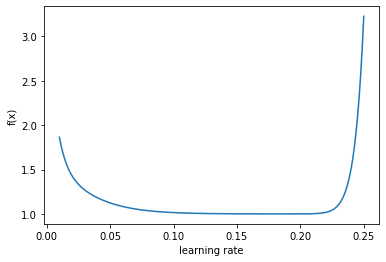

In [5]:
lrs = np.linspace(0.01, 0.25, 1000)
results = np.vectorize(lambda lr: f(gd_const_lr(grad, x0, lr, max_epoch=10)[-1]))(lrs)

plt.plot(lrs, results)
plt.xlabel('learning rate')
plt.ylabel('f(x)')
plt.show()

На этих 4 графиках наглядно видно как ведёт себя градиентный спуск с разной длиной шага на 20 итерациях.

* маленький - медленно сходится к точке минимума
* неплохой - сходится быстрее
* большой - медленно сходится, перескакивая точку минимума
* слишко большой - рассходится

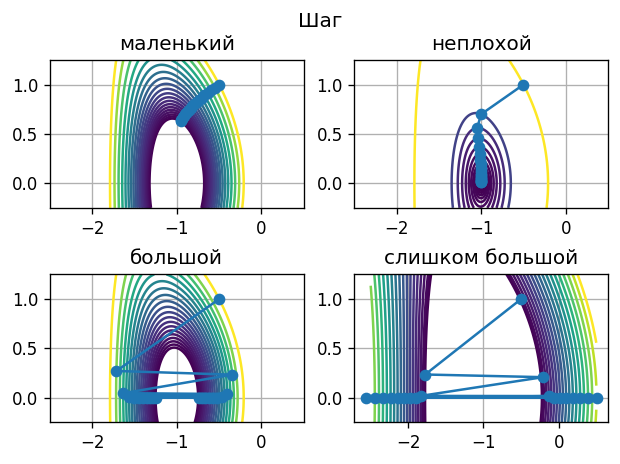

In [6]:
t = np.linspace(-1.5, 1.5, 1000)
X, Y = np.meshgrid(t - 1, (t + 1) / 2)
fig = plt.figure(dpi=120)
fig.suptitle('Шаг')


def plot_const_lr(n: int, lr: float, title: str):
  points = gd_const_lr(grad, x0, lr, max_epoch=20)
  plt.subplot(n)
  plt.grid(True)
  plt.title(title)
  plt.plot(points[:, 0], points[:, 1], 'o-')
  plt.contour(X, Y, f(np.array([X, Y])), levels=sorted([f(p) for p in points]))


plot_const_lr(221, 0.01, 'маленький')
plot_const_lr(222, 0.1, 'неплохой')
plot_const_lr(223, 0.243, 'большой')
plot_const_lr(224, 0.255, 'слишком большой')
plt.subplots_adjust(hspace=0.45)
plt.show()

## Learning rate scheduling

Реализации градиентного спуска со ступенчатой и экспоненциальной
функциями изменения шага.

In [7]:
def gd_stepping_lr(
        grad: Callable[[np.ndarray], np.ndarray],
        x0: np.ndarray,
        a0: float, # initial learning rate
        d: float,  # decay parameter
        r: int,    # droprate
        max_epoch: int = 10,
        eps: float = 0
) -> np.ndarray:
  def step(points: list) -> float:
    return a0 * d ** ((1 + len(points)) // r)

  return grad_descent(grad, x0, step, max_epoch, eps)


def gd_exponential_lr(
        grad: Callable[[np.ndarray], np.ndarray],
        x0: np.ndarray,
        a0: float, # initial learning rate
        d: float,  # decay parameter
        max_epoch: int = 10,
        eps: float = 0
) -> np.ndarray:
  def step(points: list) -> float:
    return a0 / math.e ** (d * len(points))

  return grad_descent(grad, x0, step, max_epoch, eps)

На этой гистограмме показано, что с переменным шагом скорость сходимости выше.

Начальный размер шага у всех спуков одинаковый - 0.21, однако в переменном случае он постепенно снижается.

Number of epoches before ||∇f(x)|| < eps:
With constant learning rate -  40
With stepping scheduling    -  40
With exponential scheduling -  40


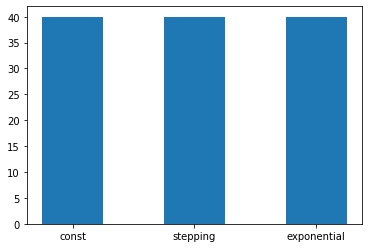

In [8]:
max_epoch: int = 40
points_const = gd_const_lr(grad, x0, 0.21, max_epoch)
points_stepping = gd_stepping_lr(grad, x0, 0.21, 0.95, 5, max_epoch)
points_exponential = gd_exponential_lr(grad, x0, 0.21, 0.02, max_epoch)

print('Number of epoches before ||∇f(x)|| < eps:')
print('With constant learning rate - ', len(points_const))
print('With stepping scheduling    - ', len(points_stepping))
print('With exponential scheduling - ', len(points_exponential))
plt.bar(['const', 'stepping', 'exponential'],
        [len(points_const), len(points_stepping), len(points_exponential)],
        width = 0.5)
plt.show()

## One-dimensional search

Реализация метода золотого сечения

(a, b) - интервал поиска минимума

In [9]:
golden_ratio = (math.sqrt(5) - 1) / 2
golden_ratio2 = (3 - math.sqrt(5)) / 2

def golden_section(
        f: Callable[[float], float],
        a: float,
        b: float,
        eps: float = 0.001
) -> float:
  h = b - a
  c = a + golden_ratio2 * h
  d = a + golden_ratio * h
  fc = f(c)
  fd = f(d)

  while h > eps:
    h *= golden_ratio
    if fc < fd:
      # go to (a, d)
      b = d
      d = c
      fd = fc
      c = a + golden_ratio2 * h
      fc = f(c)
    else:
      # go to (c, b)
      a = c
      c = d
      fc = fd
      d = a + golden_ratio * h
      fd = f(d)

  return (a + b) / 2

Реализации градиентного спуска с использованием одномерного поиска для нахождения шага на каждой итерации.

In [10]:
def gd_one_dim(
        f: Callable[[np.ndarray], float],
        grad: Callable[[np.ndarray], np.ndarray],
        x0: np.ndarray,
        max_epoch: int = 10,
        eps: float = 0.001
) -> np.ndarray:

  def step(points: list) -> float:
    x = points[-1]
    gr = grad(x)
    return golden_section(lambda lr: f(x - lr * gr), 0, 2, 1e-3)

  return grad_descent(grad, x0, step, max_epoch, eps)

Исследуем сходимость на функции f2 с градиентом grad2.

Каждое вычисление grad2 требует 4 вычислений f2.

сf и cg нужны для подсчёта числа вызовов этих фунцкий.

In [11]:
cf: int
cg: int

def f2(v):
  x, y = v
  global cf
  cf += 1
  return np.sin(0.5 * x**2 - 0.25 * y**2 + 3)*np.cos(2*x+1-np.exp(y))


def grad2(v):
  x, y = v
  global cg
  cg += 1
  h = 1e-5
  return np.array([(f2([x + h, y]) - f2([x - h, y]))/(2*h), (f2([x, y + h]) - f2([x, y - h]))/(2*h)])


x0 = np.array([-0.1, -0.4])

Сравним спуск со ступенчатым изменением шага и с одномерным поиском.

Как видно на гистограмме, число вызовов градиента grad2 у градиентного спуска с одномерным поиском заметно ниже.
Но число вызовов функции f2 примерно равно, т.к. ступенчатый спуск не требует вычисления функции для расчёта длины шага.
Однако с уменьшением eps разница числа вызовов f и grad растёт.

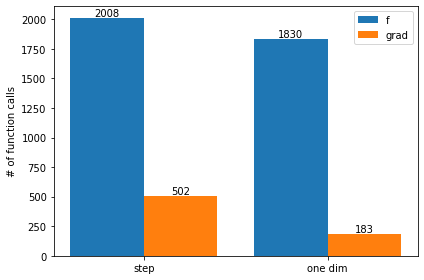

In [12]:
max_epoch=100000
eps=1e-5

labels = ['step', 'one dim']
f_counts = [0, 0]
g_counts = [0, 0]

cf, cg = 0, 0
gd_stepping_lr(grad2, x0, 0.25, 0.9, 50, max_epoch=max_epoch, eps=eps)
f_counts[0], g_counts[0] = cf, cg

cf, cg = 0, 0
gd_one_dim(f2, grad2, x0, max_epoch=max_epoch, eps=eps)
f_counts[1], g_counts[1] = cf, cg

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f_counts, width, label='f')
rects2 = ax.bar(x + width/2, g_counts, width, label='grad')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of function calls')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Gradient descent trajectory for quadratic functions

## Number of iterations dependency on k, n